In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt

from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares
from scipy.optimize import leastsq
import math

from sklearn import linear_model
from numpy.linalg import norm

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(10)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
true_para = np.array([0.31, -0.6, 0.29, -0.01, 0.011, 0.009, -0.01, -0.012, 0.015, 0.3, 0.5, 0.2, 100])
#true_para = np.array([0.21, -0.4, 0.19, -0.02, 0.016, 0.01, -0.014, -0.017, 0.02, 0.3, 0.5, 0.2, 100])
time_seg = 1
cur_time = np.arange(0, 20+time_seg, time_seg)
num_point = len(cur_time)
num_iteration = 100
n0_est = 200

In [3]:
# define the right hand side of the ODE equations in the Scipy odeint signature
from numba import njit


@njit
def rhs(X, t, theta):
    # unpack parameters
    x, y, z, n = X
    r1, r2, r3, b12, b13, b21, b23, b31, b32, x0, y0, z0, n0 = theta
    # equations
    dn_dt = r1*x*n + b12*x*y*n*n + b13*x*z*n*n + r2*y*n + b21*x*y*n*n + b23*y*z*n*n + r3*z*n + b31*x*z*n*n + b32*y*z*n*n
    dx_dt = (r1*x*n + b12*x*y*n*n + b13*x*z*n*n - x*dn_dt)/n
    dy_dt = (r2*y*n + b21*x*y*n*n + b23*y*z*n*n - y*dn_dt)/n
    dz_dt = (r3*z*n + b31*x*z*n*n + b32*y*z*n*n - z*dn_dt)/n
    return [dx_dt, dy_dt, dz_dt, dn_dt]

In [4]:
# note theta = alpha, beta, gamma, delta, xt0, yt0
theta = true_para
time = cur_time

# call Scipy's odeint function, 
x_y = odeint(func=rhs, y0=theta[-4:], t=time, args=(theta,))

In [5]:
data = pd.DataFrame(dict(
    n1_relative = np.array(x_y[:, 0]),
    n2_relative = np.array(x_y[:, 1]),
    n3_relative = np.array(x_y[:, 2]),
    absolute_sum = np.array(x_y[:, 3]),
    n1_abs = np.array(x_y[:, 0]) * n0_est,
    n2_abs = np.array(x_y[:, 1]) * n0_est,
    n3_abs = np.array(x_y[:, 2]) * n0_est, 
    n1_true = np.array(x_y[:, 0]) * np.array(x_y[:, 3]),
    n2_true = np.array(x_y[:, 1]) * np.array(x_y[:, 3]),
    n3_true = np.array(x_y[:, 2]) * np.array(x_y[:, 3]), 
))

In [6]:
for i in range (num_point-1):
    data.loc[num_point+i] = (1/time_seg)*np.log(data.loc[i+1]) - (1/time_seg)*np.log(data.loc[i])

In [7]:
x = pd.DataFrame(data.loc[0:num_point-2, ["n2_abs", "n3_abs"]])
y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n1_abs"])

regr = linear_model.LinearRegression()
regr.fit(x, y)

r1_ini = regr.intercept_[0]
b12_ini = regr.coef_[0,0]
b13_ini = regr.coef_[0,1]

In [8]:
x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n3_abs"]])
y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n2_abs"])

regr = linear_model.LinearRegression()
regr.fit(x, y)

r2_ini = regr.intercept_[0]
b21_ini = regr.coef_[0,0]
b23_ini = regr.coef_[0,1]

In [9]:
x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n2_abs"]])
y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n3_abs"])

regr = linear_model.LinearRegression()
regr.fit(x, y)

r3_ini = regr.intercept_[0]
b31_ini = regr.coef_[0,0]
b32_ini = regr.coef_[0,1]

In [10]:
theta_estimate = np.array([r1_ini, r2_ini, r3_ini, b12_ini, b13_ini, b21_ini, b23_ini, b31_ini, b32_ini, true_para[-4], true_para[-3], true_para[-2], n0_est])
theta_linear_estimate = theta_estimate
theta_linear_estimate

array([-2.58816190e-01, -4.83536067e-01, -1.49804902e+00,  5.53092159e-04,
        9.86813167e-03,  6.76280720e-03, -1.12806650e-02,  4.33093410e-04,
        2.18435414e-02,  3.00000000e-01,  5.00000000e-01,  2.00000000e-01,
        2.00000000e+02])

In [11]:
theta = theta_estimate

time = cur_time

     # call Scipy's odeint function, 
x_y_hat = odeint(func=rhs, y0=theta[-4:], t=time, args=(theta,))
data = pd.DataFrame(dict(
        n1_relative = np.array(x_y_hat[:, 0]),
        n2_relative = np.array(x_y_hat[:, 1]),
        n3_relative = np.array(x_y_hat[:, 2]),
        absolute_sum = np.array(x_y_hat[:, 3]),
        n1_abs = np.array(x_y[:, 0]) * np.array(x_y_hat[:, 3]),
        n2_abs = np.array(x_y[:, 1]) * np.array(x_y_hat[:, 3]),
        n3_abs = np.array(x_y[:, 2]) * np.array(x_y_hat[:, 3]), 
))
for i in range (num_point-1):
    data.loc[num_point+i] = (1/time_seg)*np.log(data.loc[i+1]) - (1/time_seg)*np.log(data.loc[i])    

In [12]:
theta = true_para
time = cur_time

# call Scipy's odeint function, 
real_value = odeint(func=rhs, y0=theta[-4:], t=time, args=(theta,))

In [13]:
NM = num_iteration
distance = [None] * NM
distance_min = np.inf
theta_min = theta_estimate

for m in range(NM):
    theta = theta_estimate
    time = cur_time
        
    x_y_hat = odeint(func=rhs, y0=theta[-4:], t=time, args=(theta,))
    dis_one = (np.array(real_value[:, 0] - x_y_hat[:, 0]))**2
    dis_two = (np.array(real_value[:, 1] - x_y_hat[:, 1]))**2
    dis_three = (np.array(real_value[:, 2] - x_y_hat[:, 2]))**2
    distance[m] = math.sqrt((np.sum(np.abs(dis_one)) + np.sum(np.abs(dis_two)) + np.sum(np.abs(dis_three)))/num_point/3)
   


    
    if distance[m] < distance_min:
        distance_min = distance[m]
        theta_min = theta_estimate
    
    data = pd.DataFrame(dict(
        n1_relative = np.array(x_y_hat[:, 0]),
        n2_relative = np.array(x_y_hat[:, 1]),
        n3_relative = np.array(x_y_hat[:, 2]),
        absolute_sum = np.array(x_y_hat[:, 3]),
        n1_abs = np.array(x_y[:, 0]) * np.array(x_y_hat[:, 3]),
        n2_abs = np.array(x_y[:, 1]) * np.array(x_y_hat[:, 3]),
        n3_abs = np.array(x_y[:, 2]) * np.array(x_y_hat[:, 3]), 
))
    for i in range (num_point-1):
        data.loc[num_point+i] = (1/time_seg)*np.log(data.loc[i+1]) - (1/time_seg)*np.log(data.loc[i])  
    
    x = pd.DataFrame(data.loc[0:num_point-2, ["n2_abs", "n3_abs"]])
    y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n1_abs"])
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    r1_hat = regr.intercept_[0]
    b12_hat = regr.coef_[0,0]
    b13_hat = regr.coef_[0,1]
    
    x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n3_abs"]])
    y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n2_abs"])
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    r2_hat = regr.intercept_[0]
    b21_hat = regr.coef_[0,0]
    b23_hat = regr.coef_[0,1]
    
    x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n2_abs"]])
    y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n3_abs"])
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    r3_hat = regr.intercept_[0]
    b31_hat = regr.coef_[0,0]
    b32_hat = regr.coef_[0,1]
    
    theta_estimate = np.array([r1_hat, r2_hat, r3_hat, b12_hat, b13_hat, b21_hat, b23_hat, b31_hat, b32_hat, true_para[-4], true_para[-3], true_para[-2], n0_est]) 

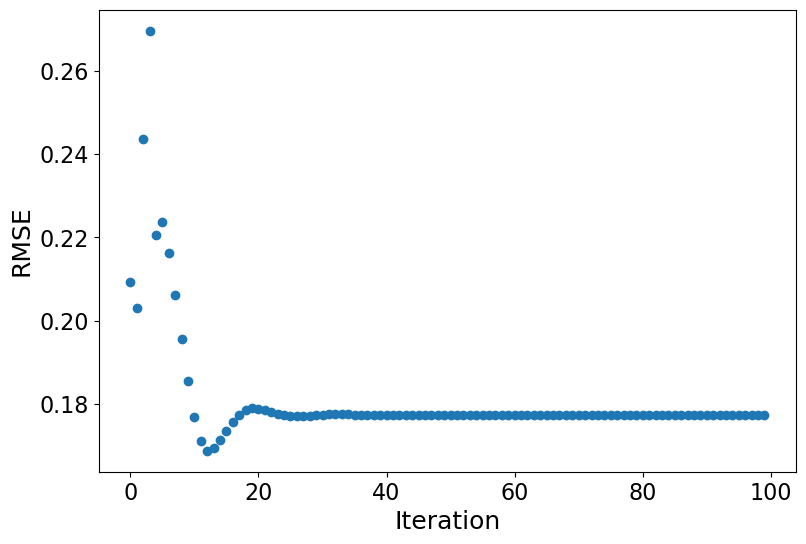

In [14]:
iter = np.arange(0, NM, 1)

fig, ax = plt.subplots(figsize=(9, 6))

ax.scatter(iter, distance)
ax.set_xlabel("Iteration", fontsize = 18)
ax.set_ylabel("RMSE", fontsize = 18)
ax.tick_params(axis='both', labelsize=16)
#ax.legend(["RMSE"], loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
fig.savefig("Fig2_1.pdf", bbox_inches='tight', dpi=300)

In [15]:
theta_min

array([-2.00107953e-01, -2.97290684e-01,  8.04823616e-02, -1.88197838e-03,
        1.14693275e-02,  8.89417720e-03, -2.14751793e-02, -1.52827257e-02,
        1.95063897e-02,  3.00000000e-01,  5.00000000e-01,  2.00000000e-01,
        2.00000000e+02])

In [16]:
theta = true_para
time = cur_time

x_y = odeint(func=rhs, y0=theta[-4:], t=time, args=(theta,))

data = pd.DataFrame(dict(
    year = cur_time,
    n1_relative = np.array(x_y[:, 0]),
    n2_relative = np.array(x_y[:, 1]),
    n3_relative = np.array(x_y[:, 2]),
    absolute_sum = np.array(x_y[:, 3]),
    n1_abs = np.array(x_y[:, 0]) * np.array(x_y[:, 3]),
    n2_abs = np.array(x_y[:, 1]) * np.array(x_y[:, 3]),
    n3_abs = np.array(x_y[:, 2]) * np.array(x_y[:, 3]), 
))

In [17]:
# plot model function
def plot_model(
    ax,
    x_y,
    time=cur_time,
    alpha=0.5,
    lw=1,
):
    ax.plot(time, x_y[:, 0], color="red", alpha=alpha, lw=lw, label="Esitmated x1")
    ax.plot(time, x_y[:, 1], color="blue", alpha=alpha, lw=lw, label="Estimated x2")
    ax.plot(time, x_y[:, 2], color="green", alpha=alpha, lw=lw, label="Estimated x3")
    ax.legend(fontsize=16)
    return ax

In [18]:
# plot data function for reuse later
def plot_data(ax):
    ax.plot(data.year, data.n1_relative, color="red", marker="o", linestyle="None", markersize=6, label="Observed x1")
    ax.plot(data.year, data.n2_relative, color="blue", marker="+", linestyle="None", markersize=6, label="Observed x2")
    ax.plot(data.year, data.n3_relative, color="green", marker="^", linestyle="None", markersize=6, label="Observed x3")
    ax.legend(fontsize=16)
    ax.set_xlim([0, len(cur_time)*time_seg])
    ax.set_xlabel("Time", fontsize = 18)
    ax.set_ylabel("Relative abundance", fontsize = 18)
    ax.set_xticks(data.year.astype(int))
    ax.set_xticklabels(ax.get_xticks())
    ax.tick_params(axis='both', labelsize=16)
    return ax

In [19]:
# function that calculates residuals based on a given theta
def ode_model_resid(thetab):
    return (
        np.abs(data[["n1_relative", "n2_relative", "n3_relative"]] - np.delete(odeint(func=rhs, y0=thetab[-4:], t=time, args=(thetab,)), -1, axis=1))
    ).values.flatten()

In [20]:
random.seed(10)
theta_est = theta_min
results = leastsq(ode_model_resid, x0=theta_est)
df = pd.DataFrame()
parameter_names = ["r1", "r2", "r3", "b12", "b13", "b21", "b23", "b31", "b32", "x0", "y0", "z0", "n0"]
df["Parameter"] = parameter_names
df["Least Squares Solution"] = results[0]
df

,Parameter,Least Squares Solution
0,r1,0.310000
1,r2,-0.600000
2,r3,0.290000
3,b12,-0.008902
4,b13,0.009792
5,b21,0.008012
6,b23,-0.008902
7,b31,-0.010683
8,b32,0.013353
9,x0,0.300000


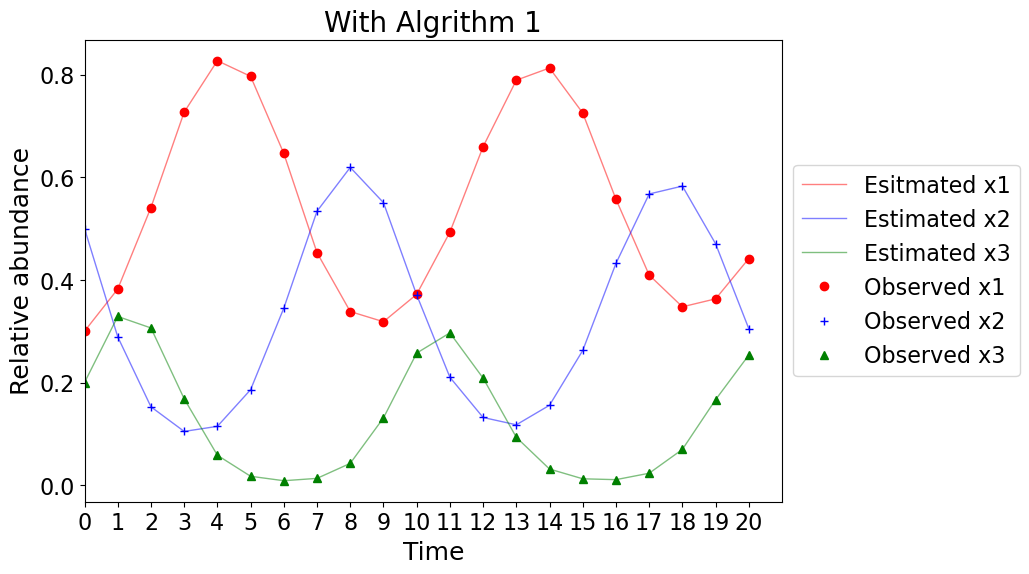

In [21]:
theta = results[0]
time = cur_time

# call Scipy's odeint function0.015, 
x_y = odeint(func=rhs, y0=theta[-4:], t=time, args=(theta,))


_, ax = plt.subplots(figsize=(9, 6))
plot_model(ax, x_y);
plot_data(ax)
plt.legend(fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("With Algrithm 1", fontsize = 20)

#plt.title("Average distance = 3.88e-2", fontsize = 18)
plt.savefig('Fig2_2.pdf', bbox_inches='tight', dpi=300)

In [22]:
dis_one = (np.array(real_value[:, 0] - x_y[:, 0]))**2
dis_two = (np.array(real_value[:, 1] - x_y[:, 1]))**2
dis_three = (np.array(real_value[:, 2] - x_y[:, 2]))**2
distance = math.sqrt((np.sum(np.abs(dis_one)) + np.sum(np.abs(dis_two)) + np.sum(np.abs(dis_three)))/num_point/3)
distance

2.1082545424943128e-10

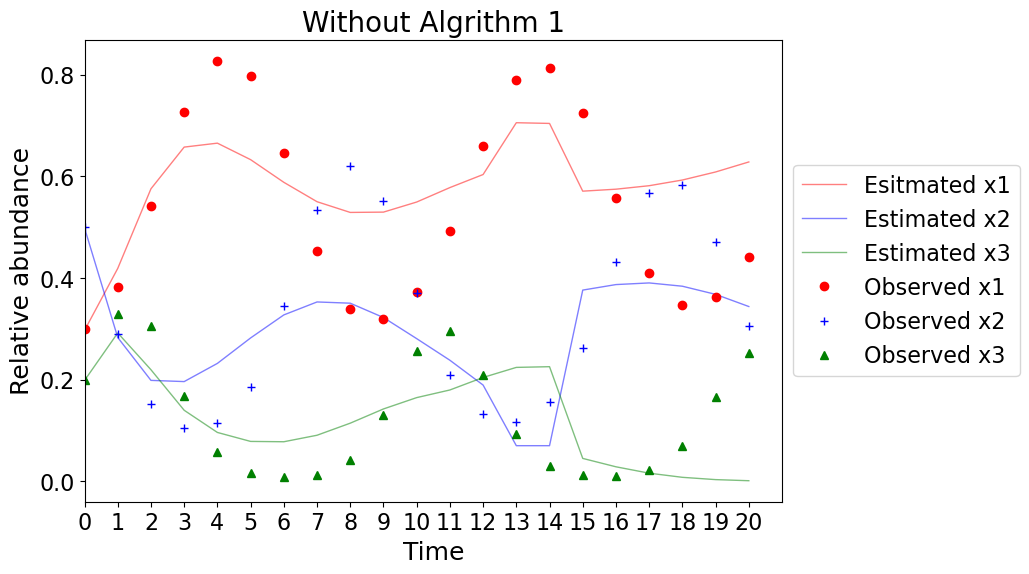

In [23]:
theta_est = theta_linear_estimate
results = leastsq(ode_model_resid, x0=theta_est)
theta = results[0]
time = cur_time

# call Scipy's odeint function0.015, 
x_y = odeint(func=rhs, y0=theta[-4:], t=time, args=(theta,))

_, ax = plt.subplots(figsize=(9, 6))
plot_model(ax, x_y);
plot_data(ax)
plt.legend(fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Without Algrithm 1", fontsize = 20)

#plt.title("Average distance = 3.88e-2", fontsize = 18)
plt.savefig('Fig2_3.pdf', bbox_inches='tight', dpi=300)

In [24]:
dis_one = (np.array(real_value[:, 0] - x_y[:, 0]))**2
dis_two = (np.array(real_value[:, 1] - x_y[:, 1]))**2
dis_three = (np.array(real_value[:, 2] - x_y[:, 2]))**2
distance = math.sqrt((np.sum(np.abs(dis_one)) + np.sum(np.abs(dis_two)) + np.sum(np.abs(dis_three)))/num_point/3)
distance

0.12203872745025592